# # Necessary libraries

## ## mecab install for colab env.

In [2]:
# Install Mecab in Colab
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 3.06 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 592 kB/s 
     |████████████████████████████████| 453 kB 69.4 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-22 02:54:01--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bi

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import load_model

## ## Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ## for loading image from google drive

In [5]:
from IPython.display import Image

# # data for training download

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f2a7ef5bdd0>)

# # data preprocessing

In [7]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

In [8]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

In [9]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거

In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('Review data for training :', len(train_data))
print('Review data for testing :', len(test_data))

Review data for training : 149931
Review data for testing : 49977


In [11]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


In [12]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any') # 
print('Number of samples for testing after preprocessing :',len(test_data))

Number of samples for testing after preprocessing : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [13]:
mecab = Mecab()

In [14]:
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [15]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [16]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [17]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [19]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [20]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('Vocabulary size(단어 집합 크기) :',total_cnt)
print('number of rare words which appear under one time(등장 빈도가 %s번 이하인 희귀 단어의 수): %s'%(threshold - 1, rare_cnt))
print("rate of rare words in the vocabulary(단어 집합에서 희귀 단어의 비율):", (rare_cnt / total_cnt)*100)
print("rate of appearance frequency of rare words in total appearance frequency(전체 등장 빈도에서 희귀 단어 등장 빈도 비율):", (rare_freq / total_freq)*100)

Vocabulary size(단어 집합 크기) : 39997
number of rare words which appear under one time(등장 빈도가 1번 이하인 희귀 단어의 수): 18212
rate of rare words in the vocabulary(단어 집합에서 희귀 단어의 비율): 45.53341500612546
rate of appearance frequency of rare words in total appearance frequency(전체 등장 빈도에서 희귀 단어 등장 빈도 비율): 0.7935245745567578


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('size of the vocabulary(단어 집합의 크기) :',vocab_size)

size of the vocabulary(단어 집합의 크기) : 21787


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307554808545264


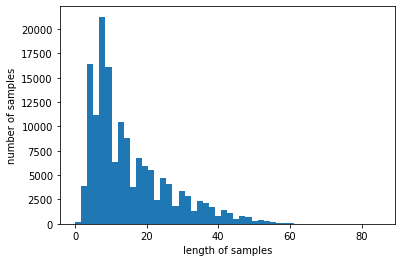

In [26]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [28]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [29]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# # load model

In [30]:
path = "/content/drive/MyDrive/Colab Notebooks/Learning/DL/NLP/Naver_shoppingmall/sensitivityAnalysis_best_model_forNavershopping_Review.h5"
loaded_model = load_model(path)

# # predict sentiment

In [31]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [32]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.80% 확률로 긍정 리뷰입니다.


# # load 'naverReview_VodanaStraightner_blue40' file

In [33]:
tmp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/빅데이터과정_파이널project_유튜브 화장품 정보/Sentiment Analysis/res/crawledData_naverReviews_VodanaStraightner_blue40.csv')
tmp

,Unnamed: 0,type,category,review,star
0,1,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,보다나 고데기 신세계네요. 머리가 깔\n보다나 고데기 신세계네요. 머리가 깔끔하게 ...,평점5
1,2,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,평소 보다나 덕후라 이번에 보다나에서 물결고데기가 나왔다는 소식을 듣고 얼른~! 4...,평점5
2,3,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,"고데기는 전부 보다나제품으로 가지고있어요판고데기,봉고데기36mm 로 가지고있는데 물...",평점5
3,4,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,한달 후기를 쓰자면제가 기존에 산 스프링 컬렉션 >초록색은지금 나온 파란색보다 무거...,평점5
4,5,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,예전부터 갖고싶어서 눈여겨보다 보통 고데기에 비해 가격이 좀 부담되어 미루다 이번에...,평점5
...,...,...,...,...,...
95,96,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,처음엔 좀 어색했는데 두번째부터는 잘하고있어요~~ 예쁘게 물결웨이브 쉽게하게되어서 ...,평점5
96,97,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,평이좋아서구매해봤는데색상이나배송도빠르고넘맘에드네여 ㅎ똥손이라서잘사용할거같아여 ㅎ\n...,평점5
97,98,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,진짜 쉬워요. 긴머린데 다 하는데 10분정도 걸리고 요령 없어도 잘 되던데 저는 너...,평점5
98,99,보다나 트리플 플로우 물결 고데기 크리미블루 40형,별점,제가 똥손이라그런지 모양이예쁘게안나오네요 ㅠㅠ 연습좀해봐야겠습니다.. 제품자체는좋아...,평점5


# # print rates of positive and negative reviews
  * positive %
  * negative %

In [34]:
def sentiment_predict_NaverShoppingReviews(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))

  if(score > 0.5):
    positive_reviews.append(score)
  else:
    negative_reviews.append(score)
  
  return positive_reviews, negative_reviews

In [35]:
reviews = tmp['review']
reviews

0     보다나 고데기 신세계네요. 머리가 깔\n보다나 고데기 신세계네요. 머리가 깔끔하게 ...
1     평소 보다나 덕후라 이번에 보다나에서 물결고데기가 나왔다는 소식을 듣고 얼른~! 4...
2     고데기는 전부 보다나제품으로 가지고있어요판고데기,봉고데기36mm 로 가지고있는데 물...
3     한달 후기를 쓰자면제가 기존에 산 스프링 컬렉션 >초록색은지금 나온 파란색보다 무거...
4     예전부터 갖고싶어서 눈여겨보다 보통 고데기에 비해 가격이 좀 부담되어 미루다 이번에...
                            ...                        
95    처음엔 좀 어색했는데 두번째부터는 잘하고있어요~~ 예쁘게 물결웨이브 쉽게하게되어서 ...
96    평이좋아서구매해봤는데색상이나배송도빠르고넘맘에드네여 ㅎ똥손이라서잘사용할거같아여 ㅎ\n...
97    진짜 쉬워요. 긴머린데 다 하는데 10분정도 걸리고 요령 없어도 잘 되던데 저는 너...
98    제가 똥손이라그런지 모양이예쁘게안나오네요 ㅠㅠ 연습좀해봐야겠습니다.. 제품자체는좋아...
99    받자말자 테스트해보니 이쁘게나오는것같은데 단발머리하기에 손에 만이 익혀야될듯싶습니다...
Name: review, Length: 100, dtype: object

In [36]:
positive_reviews = list()
negative_reviews = list()

def rate_n_or_p_reviews(reviews) :
  for review in reviews :
    positive_reviews, negative_reviews = sentiment_predict_NaverShoppingReviews(review)
  total = len(positive_reviews)+len(negative_reviews)
  print(f"positive : {len(positive_reviews) / total * 100} % , negative : {len(negative_reviews) / total * 100} % ")

In [37]:
rate_n_or_p_reviews(reviews)

positive : 80.0 % , negative : 20.0 % 
